<a href="https://colab.research.google.com/github/gongx030/etv2_pioneer/blob/master/scRNA_seq_D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of scRNA-seq of Etv2 induced reprogramming at D0 and D1

by Wuming Gong



Explore the diversified MEF population and see which subpopulation differentiated into HE population

In [1]:
start_time0 <- Sys.time()

### Install external packages

In [2]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libgsl23 libgslcblas0"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html"                                                           

In [3]:
system('apt-get install libcairo2-dev', intern = TRUE) # required by R package ComplexHeatmap 

[1] "Reading package lists..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 [2] "Building dependency tree..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
 [3] "Reading state information..."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
 [4] "The following additional packages will be installed:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 [5] "  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
 [6] "Suggested packages:"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
 [7] "  libcairo2-doc"                                                                                                       

In [4]:
system('apt-get install libudunits2-dev') # required by R package 'units'

In [5]:
system('apt-get install -y libgdal-dev libgeos-dev libproj-dev') # required by R package sf

### Install R packages

In [6]:
install.packages('BiocManager')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
required_packages <- c(
  'devtools',
  'ggplot2', 'circlize', 'ComplexHeatmap',
  'TxDb.Mmusculus.UCSC.mm10.knownGene',
  'BiocGenerics', 'DelayedArray', 'DelayedMatrixStats', 'limma', 'S4Vectors', 'SingleCellExperiment', 'SummarizedExperiment', 'batchelor', 'Matrix.utils', 'units', 'sf' # required by Monocle3
  , 'org.Mm.eg.db', 'ChIPseeker', 'clusterProfiler', 'ggplot2', 'tidyr', 
  'biomaRt', 'GO.db','biomaRt', 'ReactomePA', 'ggnewscale',
  'GO.db' 
)

In [8]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'circlize', 'ComplexHeatmap',
  'TxDb.Mmusculus.UCSC.mm10.knownGene', 'BiocGenerics', 'DelayedArray',
  'DelayedMatrixStats', 'limma', 'S4Vectors', 'SingleCellExperiment',
  'SummarizedExperiment', 'batchelor', 'Matrix.utils', 'units', 'sf',
  'org.Mm.eg.db', 'CHIPseeker', 'clusterProfiler', 'biomaRt', 'GO.db',
  'ReactomePA', 'ggnewscale'

Warning message:
“package ‘CHIPseeker’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message:
“Perhaps you meant ‘ChIPseeker’ ?”
also installing the dependencies ‘bit’, ‘Rhtslib’, ‘formatR’, ‘bit64’, ‘plogr’, ‘bitops’, ‘zlibbioc’, ‘Rsamtools’, ‘GenomicAlignments’, ‘rhdf5filters’, ‘lambda.r’, ‘futile.options’, ‘data.table’, ‘gridExtra’, ‘fastmatch’, ‘tweenr’, ‘polycli

### Install Monocle3 from github

In [9]:
devtools::install_github('cole-trapnell-lab/leidenbase', force = TRUE)


✔  checking for file ‘/tmp/Rtmp7vgC6C/remotes4a779cbd5f/cole-trapnell-lab-leidenbase-8c52ebc/DESCRIPTION’
─  preparing ‘leidenbase’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories (418ms)
─  building ‘leidenbase_0.1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [10]:
devtools::install_github('cole-trapnell-lab/monocle3', force = TRUE)

lifecycle    (0.2.0 -> 1.0.0   ) [CRAN]
sitmo        (NA    -> 2.0.1   ) [CRAN]
gtools       (NA    -> 3.8.2   ) [CRAN]
gdata        (NA    -> 2.18.0  ) [CRAN]
raster       (NA    -> 3.4-5   ) [CRAN]
sp           (NA    -> 1.4-5   ) [CRAN]
jquerylib    (NA    -> 0.1.3   ) [CRAN]
sass         (NA    -> 0.3.1   ) [CRAN]
promises     (1.1.1 -> 1.2.0.1 ) [CRAN]
warp         (NA    -> 0.2.0   ) [CRAN]
parallelly   (NA    -> 1.23.0  ) [CRAN]
listenv      (NA    -> 0.8.0   ) [CRAN]
globals      (NA    -> 0.14.0  ) [CRAN]
future       (NA    -> 1.21.0  ) [CRAN]
mime         (0.9   -> 0.10    ) [CRAN]
waldo        (0.2.3 -> 0.2.4   ) [CRAN]
testthat     (3.0.1 -> 3.0.2   ) [CRAN]
dqrng        (NA    -> 0.2.1   ) [CRAN]
RcppProgress (NA    -> 0.4.2   ) [CRAN]
RcppAnnoy    (NA    -> 0.0.18  ) [CRAN]
RSpectra     (NA    -> 0.16-0  ) [CRAN]
FNN          (NA    -> 1.1.3   ) [CRAN]
gmodels      (NA    -> 2.18.1  ) [CRAN]
expm         (NA    -> 0.999-6 ) [CRAN]
coda         (NA    -> 0.19-4  ) [CRAN]


Skipping 9 packages not available: SummarizedExperiment, S4Vectors, limma, DelayedMatrixStats, DelayedArray, BiocGenerics, batchelor, SingleCellExperiment, Biobase

Installing 53 packages: lifecycle, sitmo, gtools, gdata, raster, sp, jquerylib, sass, promises, warp, parallelly, listenv, globals, future, mime, waldo, testthat, dqrng, RcppProgress, RcppAnnoy, RSpectra, FNN, gmodels, expm, coda, LearnBayes, deldir, spData, cachem, bslib, sourcetools, xtable, httpuv, slider, modeldata, furrr, zoo, uwot, speedglm, spdep, slam, shiny, Rtsne, RhpcBLASctl, rsample, RANN, pscl, proxy, plotly, pheatmap, pbmcapply, pbapply, lmtest

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmp7vgC6C/remotes4a7d305771/cole-trapnell-lab-monocle3-4c01d89/DESCRIPTION’
─  preparing ‘monocle3’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘monocle3_0.2.3.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Load R packages

In [11]:
library(devtools)

Loading required package: usethis



In [12]:
library(SummarizedExperiment)
library(RColorBrewer)
library(monocle3)
library(dplyr)
library(ggplot2)
library(Matrix)
library(circlize)
library(igraph)
library(ComplexHeatmap)
library(org.Mm.eg.db)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(clusterProfiler)
library(ggplot2)
library(tidyr)
library(biomaRt)
library(Matrix)
library(GO.db)
library(matrixStats)
library(ComplexHeatmap)
library(stringr)
library(DOSE)
library(ReactomePA)
library(ggnewscale)
library(GOSemSim)
library(enrichplot)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

## Load processed scRNA-seq data

In [13]:
remote_rds_file <- 'https://s3.msi.umn.edu/gongx030/etv2_pioneer/data/processed_Etv2_scRNAseq.rds'
system(sprintf('wget -x -c -nH %s', remote_rds_file))

In [14]:
local_rds_file <- gsub('https://s3.msi.umn.edu/', './', remote_rds_file)
se <- readRDS(local_rds_file)
table(colData(se)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 

## Subset the cells from MEF and D1

In [15]:
se <- se[, colData(se)$group %in% c('MEF_NoDox', 'MEF_Dox_D1')]

In [16]:
table(colData(se)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948           0           0           0 

## Trajectory analysis

In [17]:
num_pca_dim <- 50L
min_expr_cells <- 10L
k_neighbors <- 200L

In [18]:
counts <- assays(se)$counts
cell_metadata <- colData(se)
colnames(counts) <- 1:ncol(counts)
rownames(cell_metadata) <- 1:ncol(counts)
gene_metadata <- rowData(se)
rownames(counts) <- gene_metadata[, 'name']
rownames(gene_metadata) <- gene_metadata[, 'name']
gene_metadata$gene_short_name <- gene_metadata[, 'name']

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



In [19]:
x <- new_cell_data_set(counts, cell_metadata = cell_metadata, gene_metadata = gene_metadata)

In [20]:
x <- x[rowSums(assays(x)$counts > 0) >= min_expr_cells, ]

In [21]:
x <- preprocess_cds(x, method = 'PCA', num_dim = num_pca_dim)

In [22]:
x <- reduce_dimension(x, reduction_method = 'UMAP', verbose = TRUE, cores = 2L)

No preprocess_method specified, using preprocess_method = 'PCA'

Note: reduce_dimension will produce slightly different output each time you run it unless you set 'umap.fast_sgd = FALSE' and 'cores = 1'

Running Uniform Manifold Approximation and Projection

22:49:44 UMAP embedding parameters a = 1.577 b = 0.8951

22:49:44 Read 4510 rows and found 50 numeric columns

22:49:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:49:45 Writing NN index file to temp file /tmp/Rtmp7vgC6C/file4a8481673

22:49:45 Searching Annoy index using 2 threads, search_k = 1500

22:49:46 Annoy recall = 100%

22:49:46 Commencing smooth kNN distance calibration using 2 threads

22:49:48 Initializing from normalized Laplacian + noise

22:49:48 Commencing optimization for 500 epochs, with 96

In [23]:
x <- cluster_cells(x, reduction_method = 'UMAP', k = k_neighbors)

In [24]:
x <- learn_graph(x, use_partition = FALSE)

  |======================================================================| 100%


In [25]:
x

class: cell_data_set 
dim: 13669 4510 
metadata(2): cds_version citations
assays(1): counts
rownames(13669): Mrpl15 Lypla1 ... CAAA01118383.1 CAAA01147332.1
rowData names(7): id name ... clusters gene_short_name
colnames(4510): 1 2 ... 4509 4510
colData names(8): barcodes group ... cluster Size_Factor
reducedDimNames(2): PCA UMAP
altExpNames(0):

## Plot the trajectories

Warning message:
“`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


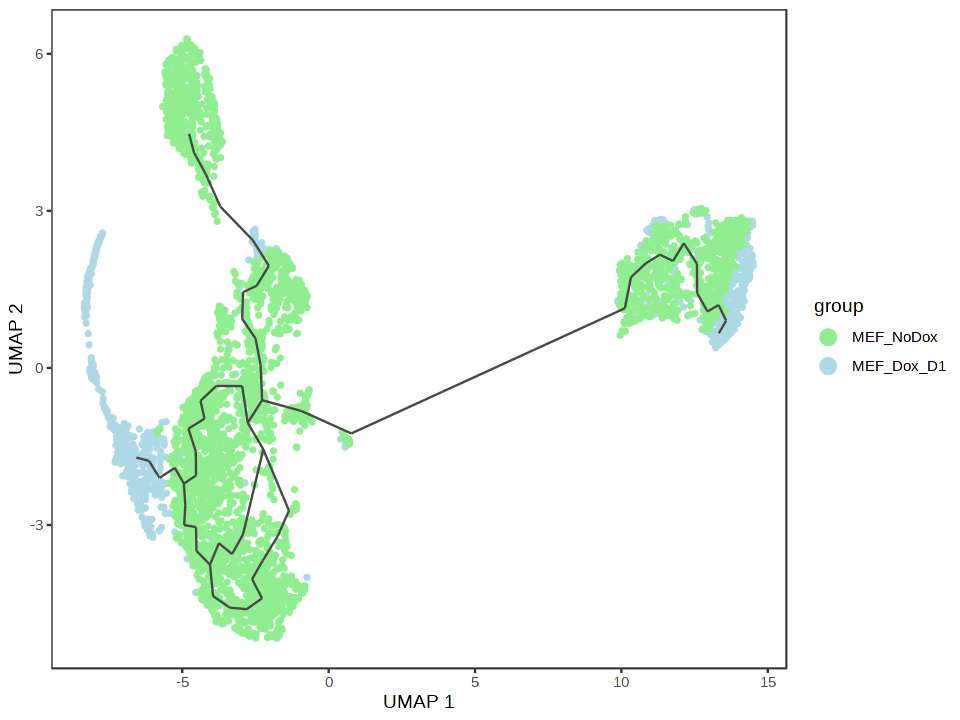

In [26]:
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x, 
  label_groups_by_cluster = FALSE,  
  color_cells_by = "group", 
  group_label_size = 4,
  show_trajectory_graph = TRUE,
  label_cell_groups = FALSE,
  label_roots = FALSE,
  label_leaves = FALSE,
  label_branch_points = FALSE,
  trajectory_graph_segment_size = 0.5,
  cell_size = 1,
) + scale_color_manual(
    values = c(
      "MEF_NoDox" = "lightgreen", 
      "MEF_Dox_D1" = "lightblue"
    ),
    name = 'group'
  ) +
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

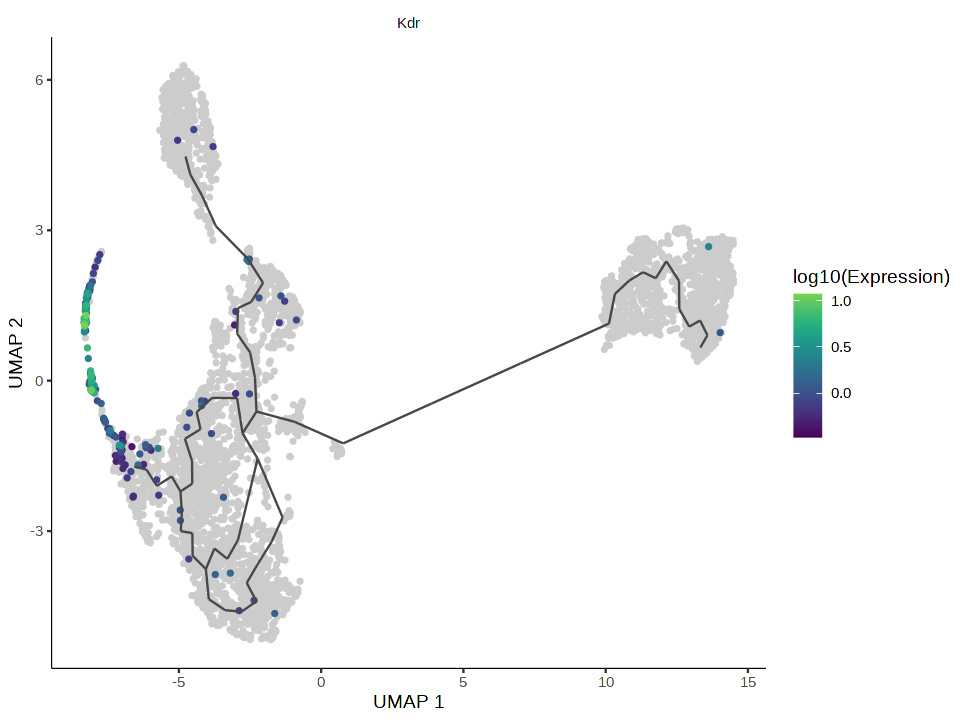

In [98]:
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x, 
  gene = 'Kdr',
  label_groups_by_cluster = FALSE,  
  color_cells_by = "group", 
  group_label_size = 4,
  show_trajectory_graph = TRUE,
  label_cell_groups = FALSE,
  label_roots = FALSE,
  label_leaves = FALSE,
  label_branch_points = FALSE,
  trajectory_graph_segment_size = 0.5,
  cell_size = 1,
)

## Determine the center vertices of each cell type

In [27]:
groups <- unique(colData(x)$group)
CT <- sparseMatrix(
  i = 1:ncol(x),
  j = as.numeric(factor(colData(x)$group, groups)),
  dims = c(ncol(x), length(groups)),
  dimnames = list(NULL, groups)
) # cell id ~ cell type

In [28]:
CV <- sparseMatrix(
  i = 1:ncol(x),
  j = x@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex,
  dims = c(ncol(x), max(x@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex))
) # cell ~ vertex

In [29]:
VT <- as(t(CV), 'dgCMatrix') %*% CT # vertex ~ cell type

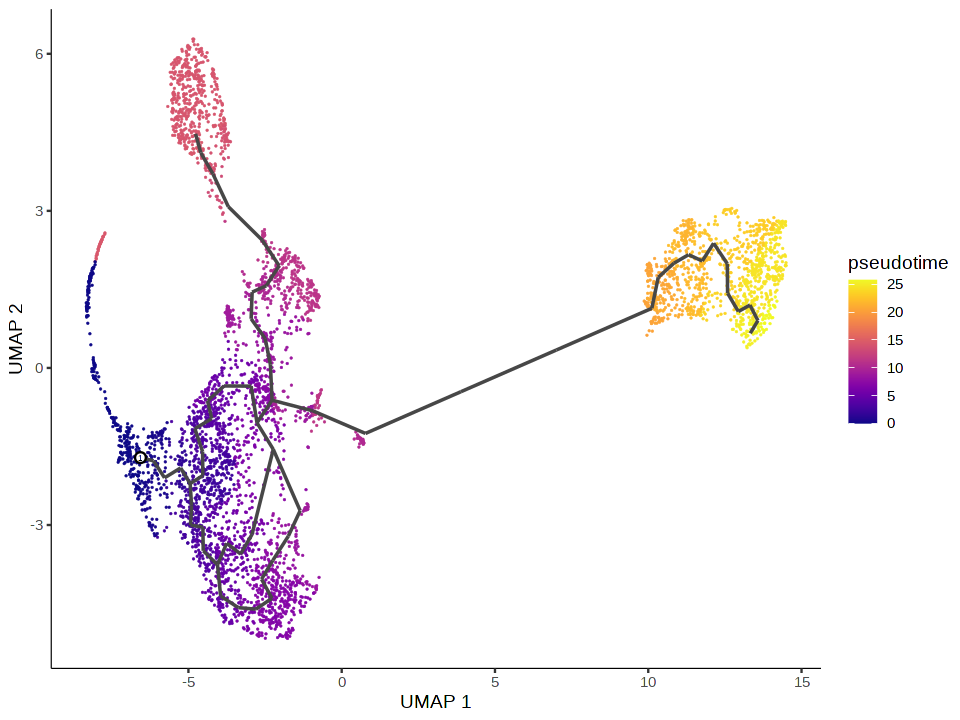

In [30]:
C1_center <- order(VT[, 'MEF_Dox_D1'], decreasing = TRUE)[1]
x <- order_cells(x, root_pr_nodes = sprintf('Y_%d', C1_center))
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x,
  color_cells_by = "pseudotime",
  label_cell_groups=FALSE,
  label_leaves=FALSE,
  label_branch_points=FALSE,
  graph_label_size=1.5
)

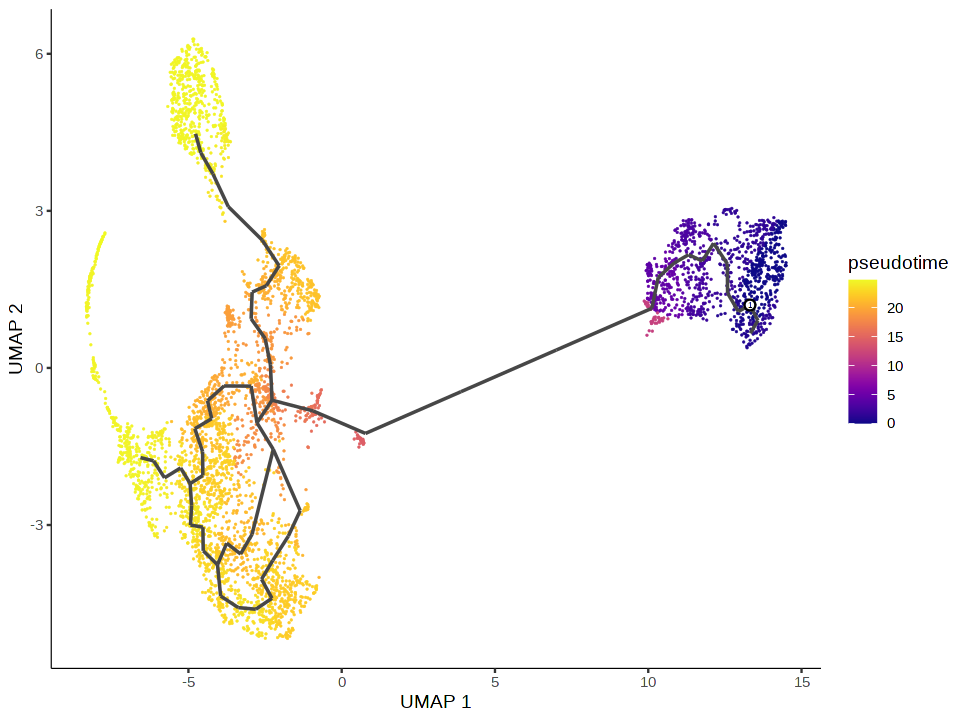

In [31]:
C2_center <- order(VT[, 'MEF_Dox_D1'], decreasing = TRUE)[2]
x <- order_cells(x, root_pr_nodes = sprintf('Y_%d', C2_center))
options(repr.plot.width = 8, repr.plot.height = 6)
plot_cells(
  x,
  color_cells_by = "pseudotime",
  label_cell_groups=FALSE,
  label_leaves=FALSE,
  label_branch_points=FALSE,
  graph_label_size=1.5
)

## Find the shortest pathway between cell types

In [32]:
graph <- x@principal_graph_aux[["UMAP"]]$stree %>% 
  graph.adjacency() # graph of vertices only

In [33]:
path <- shortest_paths(graph, from = C1_center, to = C2_center)$vpath[[1]] %>%
  as.numeric()

Remove the vertices that have no associated cells

In [34]:
path <- path[colSums(CV[, path] ) > 0]

## Calculate the aggregated normalized counts for each vertex along the path

In [35]:
x_path <- log(assays(x)$counts + 1) %*% CV[, path] %*% Diagonal(x = 1 / (colSums(CV[, path]) +1 ))

## Find the genes that are significantly up-regulated in each of three trajectories

In [36]:
res <- do.call('rbind', lapply(1:nrow(x_path), function(i){
  mod <- lm(
    y ~ pseudotime, 
    data.frame(
      y = x_path[i, ],
      pseudotime = 1:ncol(x_path)
    )
  )
  coef(summary(mod))[2, c(1, 4)]
}))

In [37]:
rownames(res) <- rownames(x_path)

In [38]:
res_top <- res %>% 
  as.data.frame() %>%
  filter(Estimate > 0) %>%
  arrange(`Pr(>|t|)`) %>% 
  head(10)
res_top

,Estimate,Pr(>|t|)
,<dbl>,<dbl>
Psmc5,0.0199059311,0.003778008
Etfb,0.0160377615,0.003824109
Cops6,0.0241686442,0.004814933
Cope,0.0106676139,0.006397893
Acy1,0.0013744756,0.010456812
Prmt1,0.0294123128,0.013145348
Acot10,0.0005293154,0.013650497
Fdps,0.0093418268,0.020296699
Nthl1,0.0015615180,0.023108444


In [39]:
res_bottom <- res %>% 
  as.data.frame() %>%
  filter(Estimate < 0) %>%
  arrange(`Pr(>|t|)`) %>% 
  head(10)
res_bottom

,Estimate,Pr(>|t|)
,<dbl>,<dbl>
Ylpm1,-0.02955021,6.458971e-15
Prrc2c,-0.07403798,1.057186e-14
Tmem245,-0.03952889,3.510028e-14
Phip,-0.03582109,4.242656e-14
Ly6e,-0.05623937,5.423112e-14
Sypl,-0.04267287,6.627477e-14
Ankrd11,-0.05477586,6.747071e-14
Gclc,-0.02627629,7.007112e-14
Zfhx4,-0.03612209,7.694440e-14


In [40]:
y <- x_path[c(rownames(res_top), rownames(res_bottom), 'Kdr'), ] %>% 
  as.matrix() %>% 
  t() %>%
  scale() %>%
  t()

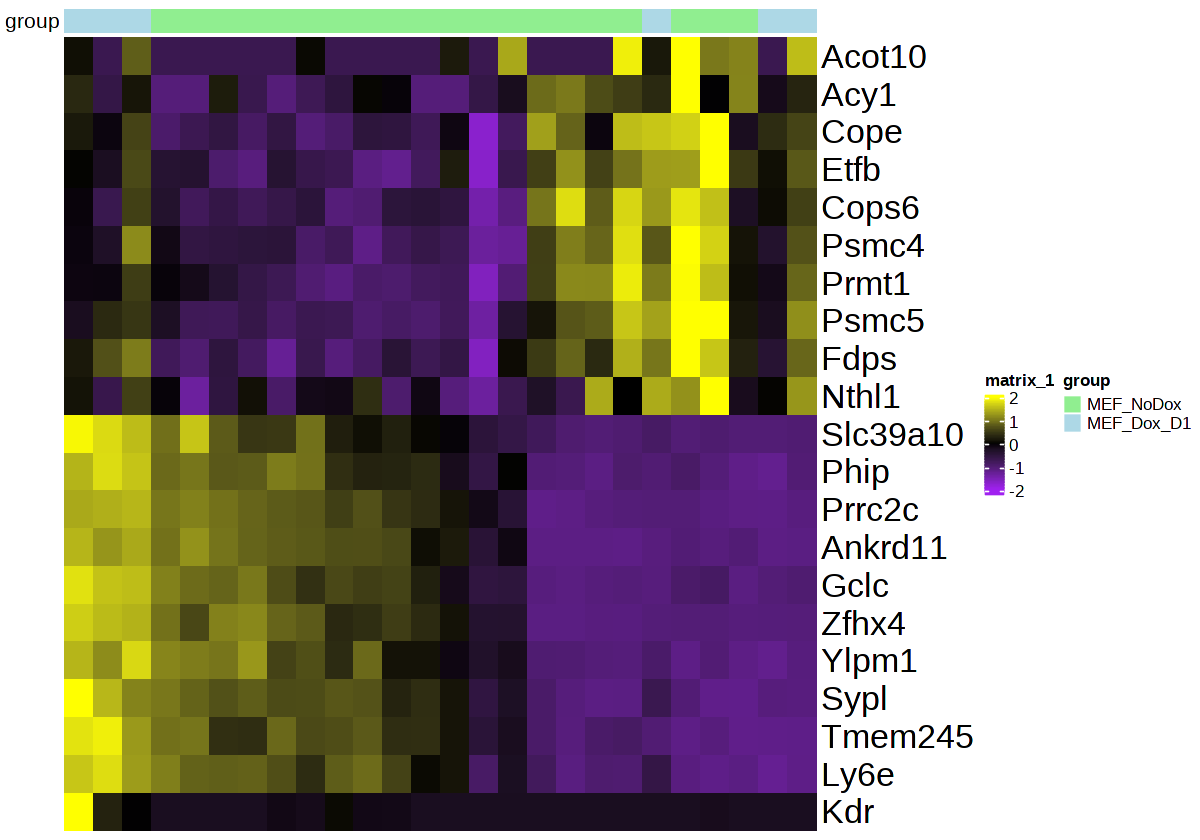

In [41]:
options(repr.plot.width = 10, repr.plot.height = 7)
col_fun <- colorRamp2(c(-2, 0, 2), c("purple", "black", "yellow"))
column_annotation <-  columnAnnotation(
  group = colData(x)$group[CV[, path] %>% t() %>% max.col()],
  col = list(
    group = c(
      "MEF_NoDox" = "lightgreen", 
      "MEF_Dox_D1" = "lightblue"
    )
  ),
  show_legend = TRUE,
  annotation_name_side = 'left'
)
Heatmap(
  y,
  cluster_rows = TRUE,
  cluster_columns = FALSE,
  show_column_dend = FALSE,
  show_row_dend = FALSE,
  show_column_names = FALSE,
  show_row_names = TRUE,
  col = col_fun,
  row_names_gp = gpar(fontsize = 20),
  top_annotation = column_annotation
) 

## Pathway analysis

In [42]:
res_top_pathway <- res %>% 
  as.data.frame() %>%
  filter(Estimate > 0) %>%
  arrange(`Pr(>|t|)`) %>% 
  head(500)
head(res_top_pathway) #Top 100 genes upregulated using the res_top filter

,Estimate,Pr(>|t|)
,<dbl>,<dbl>
Psmc5,0.019905931,0.003778008
Etfb,0.016037761,0.003824109
Cops6,0.024168644,0.004814933
Cope,0.010667614,0.006397893
Acy1,0.001374476,0.010456812
Prmt1,0.029412313,0.013145348


In [43]:
res_bottom_pathway <- res %>% 
  as.data.frame() %>%
  filter(Estimate < 0) %>%
  arrange(`Pr(>|t|)`) %>% 
  head(500)
head(res_bottom_pathway) ##Top 100 genes upregulated using the res_bottom filter

,Estimate,Pr(>|t|)
,<dbl>,<dbl>
Ylpm1,-0.02955021,6.458971e-15
Prrc2c,-0.07403798,1.057186e-14
Tmem245,-0.03952889,3.510028e-14
Phip,-0.03582109,4.242656e-14
Ly6e,-0.05623937,5.423112e-14
Sypl,-0.04267287,6.627477e-14


### Convert Gene Symbols to Entrez ID's

In [44]:
symbols_top <- rownames(res_top_pathway)
symbols_top ##gene symbols from res_top

[1] "Psmc5"         "Etfb"          "Cops6"         "Cope"         
  [5] "Acy1"          "Prmt1"         "Acot10"        "Fdps"         
  [9] "Nthl1"         "Psmc4"         "Upp1"          "Acadvl"       
 [13] "Xlr"           "Uqcrc1"        "Eno3"          "Hspb1"        
 [17] "Lgals3"        "Yjefn3"        "Hspb2"         "Renbp"        
 [21] "Psmc2"         "Capg"          "Nnat"          "Myl7"         
 [25] "Isyna1"        "Aimp2"         "Naprt"         "Eci1"         
 [29] "Rpp40"         "Psmb6"         "Lce1g"         "Samm50"       
 [33] "Rogdi"         "Bloc1s1"       "Crabp1"        "Nup62cl"      
 [37] "Psmb5"         "Slc6a15"       "3830403N18Rik" "Ndufa9"       
 [41] "Ruvbl2"        "Lce1h"         "Ndufv1"        "Fam71f2"      
 [45] "Fgf13"         "Trim54"        "Dnajc17"       "Serpinb2"     
 [49] "Fahd2a"        "Nudt17"        "Fcf1"          "Dpysl3"       
 [53] "Dynap"         "Eno1"          "Phb"           "Aldoa"        
 [57] "Fam241b"       "Xlr3a"         "Nefl"          "Hoxb5os"      
 [61] "Acot13"        "Rasgrf1"       "Chaf1b"        "Gsta1"        
 [65] "Iqcd"          "Asl"           "Ngef"          "Gzmd"         
 [69] "Xlr4a"         "Mecr"          "Arl2"          "Asns"         
 [73] "Ubb"           "Eif3g"         "Spink2"        "Gm39473"      
 [77] "Gcat"          "Hsd17b10"      "Npl"           "3300005D01Rik"
 [81] "Tbcb"          "Ddx39"         "A730056A06Rik" "Rbm42"        
 [85] "Rars"          "Atp6v0e2"      "Cct5"          "Krt19"        
 [89] "1700003F12Rik" "Gm12415"       "Eno1b"         "Rnh1"         
 [93] "Taldo1"        "Ubl7"          "Apip"          "Igfbp6"       
 [97] "Rbks"          "Psmd4"         "1700012B09Rik" "Eif2s3y"      
[101] "Wdr18"         "Stmn2"         "Gm20939"       "Ech1"         
[105] "Psmc3"         "Gm34304"       "Fuz"           "Gm17322"      
[109] "Wnt7b"         "Ifi27l2b"      "Bckdha"        "Hoxc5"        
[113] "Gsto2"         "S100a11"       "Gm26760"       "Hist1h2bc"    
[117] "Phgdh"         "Ctnnbl1"       "Hist1h4a"      "Isg15"        
[121] "Eef1d"         "Il24"          "Immp2l"        "AC123724.1"   
[125] "Cbr1"          "Hoxb8"         "Gm3573"        "Gm47708"      
[129] "Acta1"         "Pkm"           "Ccdc96"        "Pfkl"         
[133] "Uap1l1"        "Ramp3"         "Zpbp"          "Fam57b"       
[137] "9930004E17Rik" "Capn12"        "Vps28"         "Trmu"         
[141] "Fxyd2"         "Cib1"          "Cdkn2a"        "Gm44148"      
[145] "Lgals1"        "Cct7"          "Pacrg"         "D630033O11Rik"
[149] "AW011738"      "Mettl7b"       "Aspscr1"       "Ccs"          
[153] "Gm7945"        "Csf2ra"        "Ivl"           "Pold2"        
[157] "Il33"          "Ribc1"         "Slc25a5"       "Cap2"         
[161] "Mrpl39"        "Tspo"          "Pdlim2"        "Fyb"          
[165] "Actg2"         "Elavl4"        "Esd"           "Alad"         
[169] "Gm19589"       "S100a1"        "Gm14547"       "Acsbg1"       
[173] "Atp5o"         "Urod"          "Sssca1"        "Mocos"        
[177] "Kyat1"         "Pi15"          "Tpm2"          "Ndufs8"       
[181] "8430423G03Rik" "Park7"         "Lgi2"          "Micalcl"      
[185] "Ethe1"         "Mrpl46"        "Trap1"         "Eif2b3"       
[189] "Gm49207"       "D7Ertd443e"    "Mtx1"          "Mdk"          
[193] "Ptgs2os2"      "Hoxd3os1"      "Add2"          "Gm26799"      
[197] "Tnnt2"         "Gm31752"       "Gm4950"        "Ndufb10"      
[201] "Gbp3"          "Fh1"           "Ppm1j"         "Ucn2"         
[205] "Lor"           "Blvrb"         "1700023F06Rik" "Ppp5c"        
[209] "Lce1f"         "Hist1h4b"      "Nppb"          "Gm13594"      
[213] "Exoc7"         "1700034P13Rik" "Trappc6a"      "Psmd13"       
[217] "Mdh2"          "1700048O20Rik" "Dctn3"         "Psmb3"        
[221] "Rhox5"         "Gm9833"        "Ifi209"        "Prl"          
[225] "Acot8"         "Rpp25"         "Sytl1"         "Gm36495"      
[229] "Gm879

In [45]:
symbols_bottom <- rownames(res_bottom_pathway)
symbols_bottom ##gene symbols from res_bottom

[1] "Ylpm1"         "Prrc2c"        "Tmem245"       "Phip"         
  [5] "Ly6e"          "Sypl"          "Ankrd11"       "Gclc"         
  [9] "Zfhx4"         "Slc39a10"      "Taf1d"         "Ahctf1"       
 [13] "Acaca"         "Gtf3c2"        "Nav3"          "Ddost"        
 [17] "Prpf38b"       "Cpd"           "Mtdh"          "Ppm1a"        
 [21] "Eif2s3x"       "Wnk1"          "Elovl6"        "Eif4g1"       
 [25] "Zfp106"        "Heatr5a"       "Alyref"        "Gxylt1"       
 [29] "Tm4sf1"        "Tspan4"        "Zc3h4"         "Hnrnph1"      
 [33] "Prrc2b"        "Txndc5"        "Suz12"         "Eea1"         
 [37] "Cpsf2"         "Pam"           "Atp11c"        "Ccdc47"       
 [41] "Slc12a2"       "Bptf"          "Lztfl1"        "Macf1"        
 [45] "Mycbp2"        "Pabpc4"        "Man1a2"        "Ankrd26"      
 [49] "Smc1a"         "Matr3"         "Larp1"         "Asph"         
 [53] "Baz1b"         "Cep170"        "Amfr"          "Ttc14"        
 [57] "Mlec"          "Zcchc11"       "Dhx36"         "Lpgat1"       
 [61] "Huwe1"         "Hnrnpa0"       "Cnot6l"        "2610507B11Rik"
 [65] "Arid1a"        "Ppic"          "Rcc2"          "Arfgef1"      
 [69] "Sacs"          "Khsrp"         "Tmed9"         "Lpl"          
 [73] "Gpatch8"       "Purb"          "Gja1"          "Tmem30a"      
 [77] "Sel1l"         "Taf15"         "Uxs1"          "Yy1"          
 [81] "Rapgef6"       "Bcap29"        "Tpbg"          "Ktn1"         
 [85] "Sfpq"          "Tra2a"         "Acsl5"         "Ipo7"         
 [89] "Phf14"         "Polr2a"        "Eif4ebp2"      "Impad1"       
 [93] "Rsbn1l"        "Evl"           "Gpd2"          "Ptp4a2"       
 [97] "Usp16"         "Abcb1b"        "Cdv3"          "Akap1"        
[101] "Gtf3c3"        "Slc3a2"        "Atr"           "Chd4"         
[105] "Ptbp1"         "Pom121"        "Prpf8"         "H2afy"        
[109] "Ssr1"          "Tmco1"         "Usp24"         "Tspan3"       
[113] "Stag1"         "Tnrc6b"        "Lbr"           "Unc5b"        
[117] "Txndc12"       "Tpr"           "Ilf3"          "Ash1l"        
[121] "Nfkb1"         "Cab39"         "Mdn1"          "Ssbp3"        
[125] "Eml4"          "Vcam1"         "Tnpo3"         "Yeats2"       
[129] "Galnt1"        "Rprd2"         "Pura"          "Tmem131"      
[133] "Pcm1"          "Alkbh8"        "Eif4b"         "Iqgap1"       
[137] "Med1"          "Dnajc10"       "Nsd2"          "Spag9"        
[141] "Pogz"          "Zfp445"        "Nup153"        "Snx27"        
[145] "Agpat5"        "Arid2"         "Col11a1"       "Birc6"        
[149] "Lman2"         "Ccdc88a"       "Gnb1"          "Canx"         
[153] "Ccnl2"         "2300009A05Rik" "Ptbp2"         "Wapl"         
[157] "Trpm7"         "Socs7"         "Tcerg1"        "Phf3"         
[161] "Akap12"        "Zfp292"        "Chka"          "Tmx3"         
[165] "Dhx33"         "4930503L19Rik" "Galnt7"        "Ptdss1"       
[169] "Sec61a1"       "Fam168b"       "Nomo1"         "Atp2b1"       
[173] "Ctcf"          "mt-Nd2"        "Eif3a"         "Bclaf1"       
[177] "Bod1"          "Eogt"          "Alcam"         "Papd5"        
[181] "Mapk6"         "Stt3b"         "Rap1gds1"      "Cnot6"        
[185] "Stt3a"         "Thoc2"         "Emp1"          "Kmt2d"        
[189] "Tcf12"         "Specc1"        "Mfsd14b"       "Creld2"       
[193] "Pnisr"         "Atp1b3"        "Ddx3x"         "Nsd3"         
[197] "Smndc1"        "Mcmbp"         "Pum2"          "9530068E07Rik"
[201] "Adgrl2"        "Leprot"        "Dhx9"          "Nufip2"       
[205] "Herc1"         "Xpo1"          "Fam3c"         "Prkar2a"      
[209] "1810032O08Rik" "Vps54"         "Bdp1"          "Grb2"         
[213] "Ubn1"          "Zfp131"        "Kpnb1"         "Kmt2e"        
[217] "Setd2"         "Zcchc14"       "Gjc1"          "Ganab"        
[221] "Plod3"         "Naa15"         "Fto"           "Ccnl1"        
[225] "Setdb1"        "Tmem109"       "Csgalnact2"    "Afdn"         
[229] "Pcnt"

In [46]:
top_id <- mapIds(org.Mm.eg.db, symbols_top, 'ENTREZID', 'SYMBOL') ##Converting symbols to geneID

'select()' returned 1:1 mapping between keys and columns



In [47]:
bottom_id <- mapIds(org.Mm.eg.db, symbols_bottom, 'ENTREZID', 'SYMBOL')##Converting symbols to geneID

'select()' returned 1:1 mapping between keys and columns



### GO Enrichment analysis 

In [48]:
top_dat <- enrichGO(gene = top_id,
                OrgDb         = org.Mm.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
        readable      = TRUE) #res_top over representation data

In [71]:
top_dat %>% 
  as.data.frame() %>% 
  filter(!str_detect(Description, 'negative|positive|regulation')) 

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0046034,GO:0046034,ATP metabolic process,18/271,253/23328,1.118839e-09,2.788460e-06,2.529489e-06,Uqcrc1/Eno3/Ndufv1/Eno1/Aldoa/Eno1b/Pkm/Pfkl/Tspo/Atp5o/Ndufs8/Park7/Khk/Hspa8/Cox6a2/Chchd10/Cox7a1/Atp5h,18
GO:0006091,GO:0006091,generation of precursor metabolites and energy,22/271,400/23328,2.007531e-09,2.788460e-06,2.529489e-06,Uqcrc1/Eno3/Bloc1s1/Ndufv1/Eno1/Aldoa/Eno1b/Taldo1/Immp2l/Pkm/Pfkl/Atp5o/Ndufs8/Park7/Trap1/Fh1/Mdh2/Khk/Cox6a2/Chchd10/Cox7a1/Atp5h,22
GO:0007005,GO:0007005,mitochondrion organization,19/271,481/23328,4.003625e-06,2.625460e-03,2.381627e-03,Samm50/Ndufa9/Phb/Hsd17b10/Immp2l/Cdkn2a/Slc25a5/Mrpl39/Tspo/Ndufs8/Park7/Mtx1/Ndufb10/Ndufb2/Chchd10/Tomm40/Cox7a1/Ndufa13/Pmaip1,19
GO:0010499,GO:0010499,proteasomal ubiquitin-independent protein catabolic process,5/271,22/23328,4.567493e-06,2.625460e-03,2.381627e-03,Psmb6/Psmb5/Psmb3/Psmb2/Psmb7,5
GO:0006119,GO:0006119,oxidative phosphorylation,9/271,108/23328,4.842353e-06,2.625460e-03,2.381627e-03,Uqcrc1/Ndufv1/Atp5o/Ndufs8/Park7/Cox6a2/Chchd10/Cox7a1/Atp5h,9
GO:0044282,GO:0044282,small molecule catabolic process,15/271,320/23328,5.670540e-06,2.625460e-03,2.381627e-03,Etfb/Upp1/Acadvl/Renbp/Eci1/Crabp1/Gcat/Npl/Bckdha/Pfkl/Esd/Park7/Acot8/Khk/Hacl1,15
GO:0009117,GO:0009117,nucleotide metabolic process,17/271,427/23328,1.174227e-05,4.077505e-03,3.698817e-03,Acot10/Upp1/Eno3/Naprt/Nudt17/Eno1/Aldoa/Eno1b/Pkm/Pfkl/Atp5o/Park7/Nppb/Acot8/Nme5/Khk/Atp5h,17
GO:0006753,GO:0006753,nucleoside phosphate metabolic process,17/271,436/23328,1.535542e-05,4.108689e-03,3.727104e-03,Acot10/Upp1/Eno3/Naprt/Nudt17/Eno1/Aldoa/Eno1b/Pkm/Pfkl/Atp5o/Park7/Nppb/Acot8/Nme5/Khk/Atp5h,17
GO:0045333,GO:0045333,cellular respiration,10/271,157/23328,1.586959e-05,4.108689e-03,3.727104e-03,Uqcrc1/Bloc1s1/Ndufv1/Immp2l/Ndufs8/Park7/Trap1/Fh1/Mdh2/Cox6a2,10


In [53]:
bottom_dat <- enrichGO(gene = bottom_id,
                OrgDb         = org.Mm.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05,
        readable      = TRUE) #res_bottom over representation data

In [70]:
 v %>% 
  as.data.frame() %>% 
  filter(!str_detect(Description, 'negative|positive|regulation')) 

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0006397,GO:0006397,mRNA processing,39/472,462/23328,5.788717e-14,4.539512e-11,3.765712e-11,Prpf38b/Alyref/Hnrnph1/Cpsf2/Dhx36/Cnot6l/Khsrp/Sfpq/Tra2a/Ptbp1/Prpf8/Rprd2/Ptbp2/Tcerg1/Thoc2/Smndc1/Dhx9/Cdk12/Ccnt1/Rbm27/Qk/Cpsf7/Scaf8/Rbbp6/Luc7l2/Prpf4b/Dhx15/Htatsf1/Mbnl1/Ptbp3/Tia1/Zc3h13/Khdrbs1/Srek1/Celf1/Gcfc2/Scaf4/Dyrk1a/Luc7l3,39
GO:0008380,GO:0008380,RNA splicing,33/472,386/23328,3.784938e-12,1.484074e-09,1.231101e-09,Prpf38b/Alyref/Hnrnph1/Khsrp/Taf15/Sfpq/Tra2a/Polr2a/Ptbp1/Prpf8/Ptbp2/Tcerg1/Thoc2/Smndc1/Dhx9/Cdk12/Qk/Luc7l2/Prpf4b/Dhx15/Htatsf1/Mbnl1/Ptbp3/Tia1/Zc3h13/Khdrbs1/Srek1/Slc38a2/Celf1/Gcfc2/Zfp638/Dyrk1a/Luc7l3,33
GO:0006402,GO:0006402,mRNA catabolic process,24/472,217/23328,1.732682e-11,6.176223e-09,5.123433e-09,Pabpc4/Larp1/Dhx36/Hnrnpa0/Cnot6l/Khsrp/Taf15/Ptbp1/Tnrc6b/Cnot6/Pum2/Dhx9/Fto/Csde1/Ythdf2/Qk/Hnrnpd/Upf1/Myef2/Xrn1/Cnot1/Rock1/Igf2bp1/Pum1,24
GO:0016570,GO:0016570,histone modification,33/472,448/23328,1.988125e-10,6.496198e-08,5.388865e-08,Suz12/Baz1b/Huwe1/Sfpq/Phf14/Usp16/Ash1l/Yeats2/Nsd2/Ctcf/Kmt2d/Nsd3/Kmt2e/Setd2/Setdb1/Usp7/Brpf1/Wdr82/Slk/Hcfc1/Ddb1/Ncor1/Brd4/Ep400/Jade1/Atrx/Brd1/Nipbl/Mier1/Kat7/Crebbp/Smarca4/Akap8,33
GO:0016569,GO:0016569,covalent chromatin modification,33/472,462/23328,4.390430e-10,1.212287e-07,1.005642e-07,Suz12/Baz1b/Huwe1/Sfpq/Phf14/Usp16/Ash1l/Yeats2/Nsd2/Ctcf/Kmt2d/Nsd3/Kmt2e/Setd2/Setdb1/Usp7/Brpf1/Wdr82/Slk/Hcfc1/Ddb1/Ncor1/Brd4/Ep400/Jade1/Atrx/Brd1/Nipbl/Mier1/Kat7/Crebbp/Smarca4/Akap8,33
GO:0006401,GO:0006401,RNA catabolic process,24/472,254/23328,4.637669e-10,1.212287e-07,1.005642e-07,Pabpc4/Larp1/Dhx36/Hnrnpa0/Cnot6l/Khsrp/Taf15/Ptbp1/Tnrc6b/Cnot6/Pum2/Dhx9/Fto/Csde1/Ythdf2/Qk/Hnrnpd/Upf1/Myef2/Xrn1/Cnot1/Rock1/Igf2bp1/Pum1,24
GO:0061157,GO:0061157,mRNA destabilization,10/472,33/23328,6.381224e-10,1.563799e-07,1.297236e-07,Dhx36/Cnot6l/Khsrp/Fto/Ythdf2/Qk/Hnrnpd/Upf1/Rock1/Pum1,10
GO:0009100,GO:0009100,glycoprotein metabolic process,27/472,332/23328,1.085621e-09,2.503952e-07,2.077132e-07,Ddost/Gxylt1/Man1a2/Arfgef1/Galnt1/Col11a1/Galnt7/Eogt/Stt3b/Stt3a/Ganab/Plod3/Csgalnact2/Chst14/Magt1/Uggt1/Alg10b/Tmem165/Mgat4b/Fkrp/Nus1/Fktn/Poglut1/Xxylt1/Ctsl/Edem1/B4galt1,27
GO:0050779,GO:0050779,RNA destabilization,10/472,36/23328,1.659647e-09,3.615263e-07,2.999010e-07,Dhx36/Cnot6l/Khsrp/Fto/Ythdf2/Qk/Hnrnpd/Upf1/Rock1/Pum1,10


In [91]:
top_terms <- c(
  'ATP metabolic process',
  'mitochondrion organization',
  'oxidative phosphorylation',
  'nucleotide metabolic process'
)


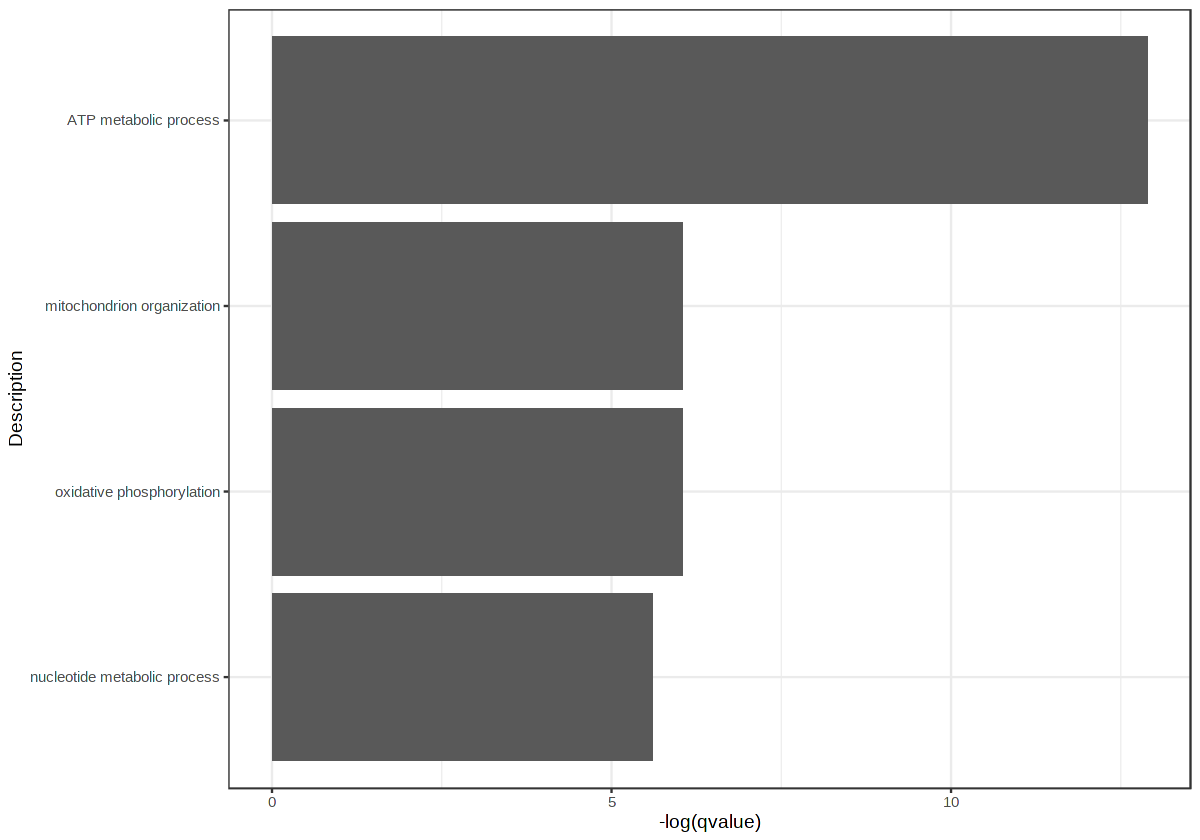

In [94]:
top_dat %>% 
  as.data.frame() %>%
  filter(Description %in% top_terms) %>%
  mutate(Description = factor(Description, rev(top_terms))) %>%
  ggplot(aes(x = Description, y = -log(qvalue))) +
    geom_bar(stat = 'identity') +
    coord_flip() +
    theme_bw() 
    

In [96]:
bottom_terms <- c(
  'mRNA processing',
  'RNA splicing',
  'histone modification',
  'glycoprotein metabolic process'
)

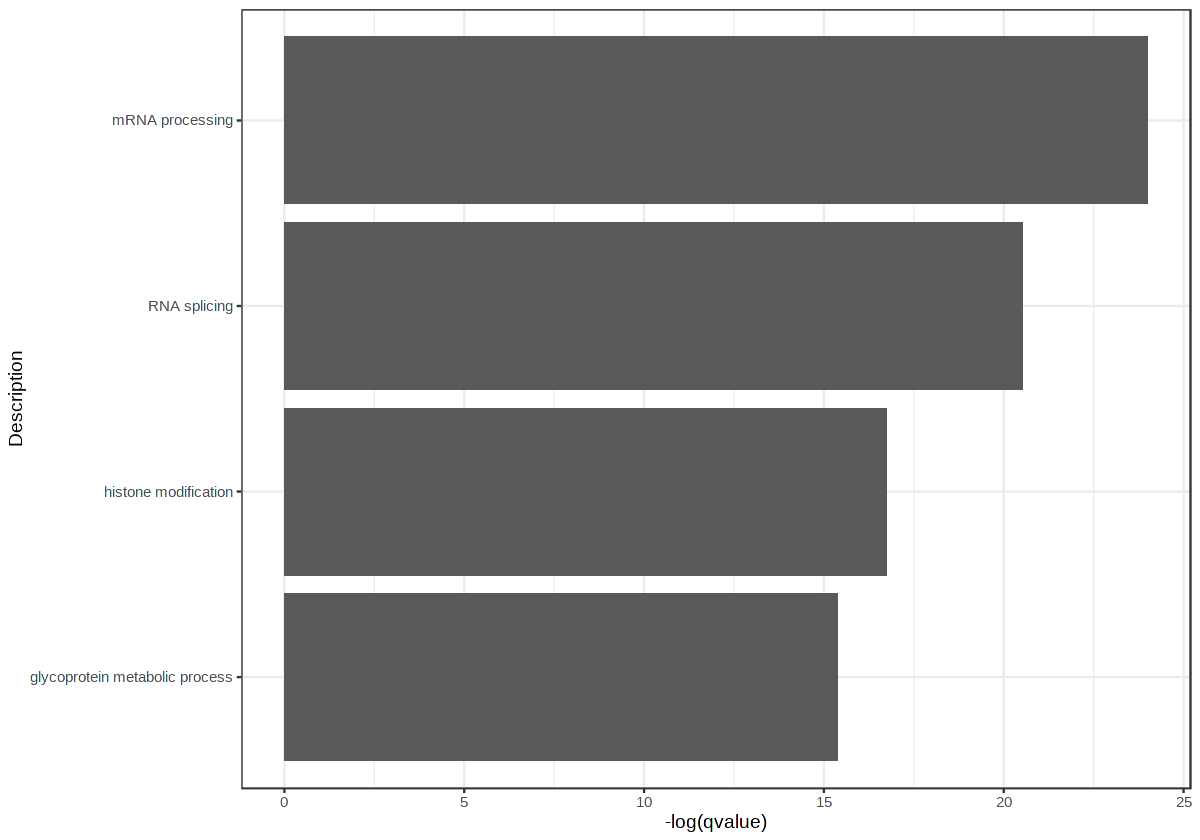

In [97]:
bottom_dat %>% 
  as.data.frame() %>%
  filter(Description %in% bottom_terms) %>%
  mutate(Description = factor(Description, rev(bottom_terms))) %>%
  ggplot(aes(x = Description, y = -log(qvalue))) +
    geom_bar(stat = 'identity') +
    coord_flip() +
    theme_bw() 
    

### KEGG pathway analysis

In [57]:
kegg_top <- enrichKEGG(gene = top_id,
                organism = 'mouse',
                keyType = 'kegg',
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05)

Reading KEGG annotation online:


Reading KEGG annotation online:




In [58]:
kegg_top %>% 
  as.data.frame() 

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
mmu05012,mmu05012,Parkinson disease,29/138,247/8907,5.182019e-18,1.036404e-15,9.218539e-16,19184/23996/22273/19181/19175/19173/66108/17995/22187/19185/19182/11740/28080/225887/57320/68015/68342/23997/26446/68198/12862/12865/26445/22223/68349/19177/66997/71679/67184,29
mmu05022,mmu05022,Pathways of neurodegeneration - multiple diseases,35/138,472/8907,2.768737e-15,2.768737e-13,2.462718e-13,19184/23996/22273/19181/19175/19173/66108/17995/18039/22187/15108/19185/19182/22422/12460/11740/28080/225887/57320/68015/68342/23997/53598/26446/68198/12862/53333/12865/26445/22223/68349/19177/66997/71679/67184,35
mmu05020,mmu05020,Prion disease,26/138,268/8907,3.553403e-14,2.368935e-12,2.107106e-12,19184/23996/22273/19181/19175/19173/66108/17995/19185/19182/11740/28080/225887/68342/23997/26446/15481/68198/12862/12865/26445/68349/19177/66997/71679/67184,26
mmu05014,mmu05014,Amyotrophic lateral sclerosis,29/138,369/8907,2.359430e-13,1.179715e-11,1.049326e-11,19184/23996/22273/19181/19175/19173/66108/17995/18039/19185/19182/12460/28080/225887/68342/23997/53598/26446/68198/12862/103172/53333/12865/26445/68349/19177/66997/71679/67184,29
mmu05016,mmu05016,Huntington disease,26/138,302/8907,5.994127e-13,2.397651e-11,2.132647e-11,19184/23996/22273/19181/19175/19173/66108/17995/19185/19182/11740/28080/225887/68342/23997/53598/26446/68198/12862/12865/26445/68349/19177/66997/71679/67184,26
mmu03050,mmu03050,Proteasome,12/138,47/8907,3.883427e-12,1.294476e-10,1.151402e-10,19184/23996/19181/19175/19173/19185/19182/23997/26446/26445/19177/66997,12
mmu05010,mmu05010,Alzheimer disease,27/138,369/8907,9.717549e-12,2.776443e-10,2.469573e-10,19184/23996/22273/19181/19175/19173/66108/17995/15108/19185/19182/22422/11740/28080/225887/68342/23997/26446/68198/12862/12865/26445/68349/19177/66997/71679/67184,27
mmu01230,mmu01230,Biosynthesis of amino acids,11/138,79/8907,3.044904e-08,7.612259e-07,6.770904e-07,109652/13808/13806/11674/109900/27053/433182/21351/236539/18746/18641,11
mmu00190,mmu00190,Oxidative phosphorylation,13/138,133/8907,1.228253e-07,2.729450e-06,2.427774e-06,22273/66108/17995/76252/28080/225887/68342/68198/12862/12865/68349/71679/67184,13


In [59]:
kegg_bottom <- enrichKEGG(gene = bottom_id,
                organism = 'mouse',
                keyType = 'kegg',
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.05)

In [60]:
kegg_bottom %>% 
  as.data.frame() 

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
mmu04141,mmu04141,Protein processing in endoplasmic reticulum,19/211,172/8907,2.093825e-08,5.297378e-06,4.870899e-06,13200/105245/17156/23802/20338/107513/66861/66890/12330/53421/68292/16430/14376/320011/67838/14827/270669/216197/192193,19
mmu00514,mmu00514,Other types of O-glycan biosynthesis,9/211,43/8907,5.553899e-07,7.025683e-05,6.460062e-05,223827/14423/108150/101351/26433/234407/224143/268880/14595,9
mmu00310,mmu00310,Lysine degradation,10/211,64/8907,2.230495e-06,1.881050e-04,1.729612e-04,192195/107823/381022/234135/69188/235626/26433/84505/234407/26432,10
mmu03013,mmu03013,RNA transport,16/211,183/8907,6.535319e-06,4.133589e-04,3.800804e-04,26905/208643/21681/230721/13688/107939/108989/75705/218210/13669/331401/103573/16211/19704/70699/13682,16
mmu00510,mmu00510,N-Glycan biosynthesis,8/211,50/8907,1.981477e-05,1.002627e-03,9.219082e-04,13200/17156/68292/16430/14376/380959/103534/14595,8
mmu00061,mmu00061,Fatty acid biosynthesis,5/211,19/8907,6.309460e-05,2.660489e-03,2.446300e-03,107476/433256/14104/14081/74205,5
mmu00564,mmu00564,Glycerophospholipid metabolism,10/211,98/8907,1.023325e-04,3.698587e-03,3.400823e-03,226856/14571/52123/12660/19210/52858/68262/75320/66586/28042,10
mmu00513,mmu00513,Various types of N-glycan biosynthesis,6/211,40/8907,3.223306e-04,9.702330e-03,8.921219e-03,13200/17156/68292/16430/103534/14595,6
mmu05203,mmu05203,Viral carcinogenesis,15/211,229/8907,3.451422e-04,9.702330e-03,8.921219e-03,107932/18033/13205/14784/252870/22215/83602/13194/18706/12912/60595/27401/12914/22631/16195,15


### Reactome Pathway analysis

In [61]:
reactome_top <- enrichPathway(gene = top_id,
                organism = "mouse",
                pvalueCutoff  = 0.05)

In [62]:
reactome_top %>%
  as.data.frame()

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-MMU-450408,R-MMU-450408,AUF1 (hnRNP D0) binds and destabilizes mRNA,15/154,56/8733,2.173890e-14,1.193465e-11,9.313401e-12,19184/23996/15507/19181/19175/19173/22187/19185/19182/23997/26446/15481/26445/19177/66997,15
R-MMU-450531,R-MMU-450531,Regulation of mRNA stability by proteins that bind AU-rich elements,16/154,85/8733,1.102831e-12,2.051607e-10,1.601005e-10,19184/23996/15507/19181/19175/19173/22187/19185/19182/23997/26446/15481/27998/26445/19177/66997,16
R-MMU-75815,R-MMU-75815,Ubiquitin-dependent degradation of Cyclin D,13/154,51/8733,2.560957e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/26445/19177/66997,13
R-MMU-1169091,R-MMU-1169091,Activation of NF-kappaB in B cells,14/154,63/8733,2.755226e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/18036/26445/19177/66997,14
R-MMU-349425,R-MMU-349425,Autodegradation of the E3 ubiquitin ligase COP1,13/154,52/8733,3.363290e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/26445/19177/66997,13
R-MMU-69601,R-MMU-69601,Ubiquitin Mediated Degradation of Phosphorylated Cdc25A,13/154,52/8733,3.363290e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/26445/19177/66997,13
R-MMU-69610,R-MMU-69610,p53-Independent DNA Damage Response,13/154,52/8733,3.363290e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/26445/19177/66997,13
R-MMU-69613,R-MMU-69613,p53-Independent G1/S DNA damage checkpoint,13/154,52/8733,3.363290e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/26445/19177/66997,13
R-MMU-8939902,R-MMU-8939902,Regulation of RUNX2 expression and activity,13/154,52/8733,3.363290e-12,2.051607e-10,1.601005e-10,19184/23996/19181/19175/19173/22187/19185/19182/23997/26446/26445/19177/66997,13


In [63]:
reactome_bottom <- enrichPathway(gene = bottom_id,
                organism = "mouse",
                pvalueCutoff  = 0.05)

In [64]:
reactome_bottom  %>%
  as.data.frame()

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-MMU-3247509,R-MMU-3247509,Chromatin modifying enzymes,19/248,203/8733,4.645730e-06,0.001581871,0.001462183,52615/93760/107932/192195/18033/107823/77044/234135/69188/235626/229542/78783/15161/234366/269424/223770/217127/20586/83796,19
R-MMU-4839726,R-MMU-4839726,Chromatin organization,19/248,203/8733,4.645730e-06,0.001581871,0.001462183,52615/93760/107932/192195/18033/107823/77044/234135/69188/235626/229542/78783/15161/234366/269424/223770/217127/20586/83796,19
R-MMU-68884,R-MMU-68884,Mitotic Telophase/Cytokinesis,5/248,12/8733,1.193460e-05,0.002709154,0.002504172,24061/20842/218914/20843/71175,5
R-MMU-429947,R-MMU-429947,Deadenylation of mRNA,6/248,25/8733,5.552588e-05,0.009453281,0.008738020,208643/231464/75705/104625/13682/234594,6
R-MMU-2468052,R-MMU-2468052,Establishment of Sister Chromatid Cohesion,4/248,10/8733,1.164958e-04,0.015866732,0.014666212,24061/20842/218914/20843,4
R-MMU-72203,R-MMU-72203,Processing of Capped Intron-Containing Pre-mRNA,17/248,227/8733,2.450691e-04,0.027815344,0.025710760,21681/59013/51786/77134/20020/107939/192159/108989/218210/331401/76479/13211/11991/269061/13204/67500/330361,17
R-MMU-75105,R-MMU-75105,Fatty acyl-CoA biosynthesis,6/248,33/8733,2.870112e-04,0.027922088,0.025809426,107476/170439/433256/14104/14081/74205,6


In [99]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] enrichplot_1.10.2                        
 [2] GOSemSim_2.16.1                          
 [3] ggnewscale_0.4.5                         
 [4] ReactomePA_1.34.0                        
 [5] DOSE_3.16.0                              